# 🛰️ RT-02: Mantenimiento Predictivo de Flota (LATAM, USD)

Mantenimiento predictivo con datos sintéticos de sensores para reducir fallas y planificar ventanas de servicio con mínimo impacto operacional.

---
id: "RT-02"
title: "Fleet Predictive Maintenance"
specialty: "Realtime / IoT"
process: "Maintain/Deliver"
level: "Intermediate"
tags: ["predictive-maintenance","iot","latam","fleet"]
estimated_time_min: 45
---

## 🔧 Instalación de Librerías

```bash
# Opción 1: Instalar librerías individuales
pip install pandas numpy matplotlib seaborn scikit-learn pyarrow

# Opción 2: Instalar todo el entorno del proyecto
pip install -e .[core,notebooks]
```

Librerías requeridas:
- `pandas`, `numpy` — datos
- `scikit-learn` — modelos (RandomForest)
- `matplotlib`, `seaborn` — visualización
- `pyarrow` — exportes Parquet

### 🗂️ Artefactos generados

| Archivo | Descripción |
|---------|-------------|
| `fleet_sensor_data.parquet` | Lecturas sintéticas de sensores por unidad |
| `feature_importance.parquet` | Importancia de variables del modelo |
| `maintenance_plan.parquet` | Sugerencias de ventana de mantenimiento y riesgo |
| `roc_curve.png` | Curva ROC del clasificador |
| `feature_importance.png` | Gráfico de importancia de variables |

In [1]:
# Configurar entorno del repositorio
import sys
from pathlib import Path
_candidates = [Path.cwd(), *Path.cwd().parents]
_repo_root = None
for _p in _candidates:
    if (_p / 'pyproject.toml').exists() or (_p / 'src').exists():
        _repo_root = _p
        break
if _repo_root is None:
    _repo_root = Path.cwd()
if str(_repo_root) not in sys.path:
    sys.path.insert(0, str(_repo_root))
data_out = _repo_root / 'data' / 'processed' / 'rt02_predictive_maintenance'
data_out.mkdir(parents=True, exist_ok=True)
print(f'✅ Entorno listo: {_repo_root}')
print(f'💾 Salida: {data_out}')

✅ Entorno listo: f:\GitHub\supply-chain-data-notebooks
💾 Salida: f:\GitHub\supply-chain-data-notebooks\data\processed\rt02_predictive_maintenance


In [2]:
# Imports y configuración
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
sns.set(style='whitegrid')

In [3]:
# Validación rápida de librerías y entorno (ejecutar al inicio)
import importlib
for lib in ["pandas","numpy","matplotlib","seaborn","sklearn","pyarrow"]:
    try:
        m = importlib.import_module(lib)
        print(f"✅ {lib} versión: {getattr(m, '__version__', 'ok')}")
    except Exception as e:
        print(f"⚠️ {lib} no disponible: {e}")
print("Entorno verificado.")

✅ pandas versión: 2.3.3
✅ numpy versión: 2.3.3
✅ matplotlib versión: 3.10.7
✅ seaborn versión: 0.13.2
✅ sklearn versión: 1.7.2
✅ pyarrow versión: 21.0.0
Entorno verificado.


## 📋 Contexto de Negocio

- Flota LATAM con variabilidad climática y operación urbana/interurbana.
- Datos de sensores: horas de motor, temperatura, vibración, alertas.
- Objetivo: predecir probabilidad de falla y sugerir ventanas de mantenimiento que minimicen impacto operativo.
- Costos y métricas en USD para comparabilidad.

### 🎲 Generación de datos sintéticos
- Unidades de flota: 300 equipos.
- Lecturas por unidad: últimas 30 observaciones agregadas (features actuales).
- Etiqueta de falla: probabilidad creciente con vibración, temperatura, horas y alertas.

In [4]:
# Generar dataset sintético de sensores
np.random.seed(123)
n_units = 300
hours = np.random.gamma(shape=5.0, scale=200.0, size=n_units)  # horas de motor
temp = np.random.normal(loc=85, scale=8, size=n_units)        # °C
vibe = np.random.normal(loc=3.0, scale=1.0, size=n_units)     # mm/s RMS
alerts = np.random.poisson(lam=1.2, size=n_units)             # conteo de alertas últimos 30 días
region = np.random.choice(['MEX','BRA','COL','PER','CHL','ARG'], size=n_units)
usage_km_month = np.random.normal(loc=4500, scale=800, size=n_units)
maint_cost_usd = np.random.uniform(150, 600, size=n_units)
# Probabilidad de falla latente
logit = -6.0 + 0.002*hours + 0.05*(temp-80) + 0.6*(vibe-2.5) + 0.35*alerts
p_fail = 1/(1+np.exp(-logit))
fail = np.random.binomial(1, p_fail)
df = pd.DataFrame({
    'unit_id': np.arange(1, n_units+1),
    'region': region,
    'hours': hours,
    'temp_c': temp,
    'vibration_rms': vibe,
    'alerts_30d': alerts,
    'usage_km_month': usage_km_month,
    'maint_cost_usd': np.round(maint_cost_usd,2),
    'fail': fail,
    'p_fail_true': p_fail
})
print(df.head())

   unit_id region        hours     temp_c  vibration_rms  alerts_30d  \
0        1    ARG   538.472806  92.687041       3.856555           0   
1        2    COL  1433.950740  99.274854       2.982609           0   
2        3    MEX   705.003804  97.704543       4.448577           2   
3        4    PER  1844.095240  85.901153       3.892200           0   
4        5    CHL   228.472442  84.985002       2.770573           3   

   usage_km_month  maint_cost_usd  fail  p_fail_true  
0     4824.856956          577.97     0     0.030039  
1     4284.384876          427.67     0     0.132528  
2     4497.272683          295.06     0     0.137570  
3     4096.333384          196.65     0     0.234795  
4     3039.977340          462.42     0     0.016602  


#### 🧪 Fundamentos de los datos sintéticos
- Distribuciones: `hours~Gamma(5,200)` captura asimetría; `temp~N(85,8)` y `vibration~N(3,1)` centradas en rangos operativos.
- Etiqueta: `p_fail = σ(β0 + β1*hours + β2*temp + β3*vibe + β4*alerts)` con enlace logístico; mayor vibración/temperatura/alertas aumenta riesgo.
- Balance: La tasa de falla resultante es moderada; si fuese muy baja, ajustar `β` o usar `class_weight` (ver modelo).
- LATAM: `region` aporta segmentación para ventanas/logística (no se usa en el modelo base para evitar leakage).

### 🧮 Modelado (clasificación)
- Modelo: `RandomForestClassifier` sencillo (evitamos dependencias extra).
- Métrica principal: AUC ROC y curva ROC.
- Importancias de características para interpretabilidad.

In [5]:
# Train/Test split y entrenamiento
features = ['hours','temp_c','vibration_rms','alerts_30d','usage_km_month']
X = df[features]
y = df['fail']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
rf = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_proba = rf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_proba)
print(f'AUC ROC: {auc:.3f}')
# Feature importance
imp = pd.DataFrame({'feature': features, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
print(imp)

AUC ROC: 0.766
          feature  importance
0           hours    0.393933
1          temp_c    0.165267
2   vibration_rms    0.164842
4  usage_km_month    0.162601
3      alerts_30d    0.113358


#### 🤖 Modelo y parámetros
- `RandomForest(n_estimators=300, max_depth=6)`: sesgo/varianza equilibrado; límite de profundidad para evitar sobreajuste.
- `class_weight='balanced'`: corrige desbalance penalizando más las clases minoritarias.
- AUC ROC: métrica umbral-independiente útil para ranking de riesgo.
- Extensiones: validación cruzada, `max_features` tuning, y calibración (`CalibratedClassifierCV`) si se requieren probabilidades bien calibradas.

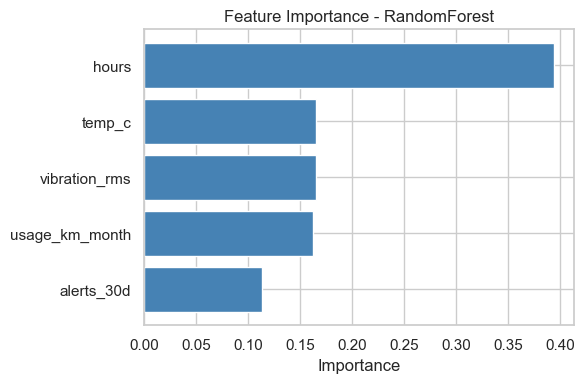

In [6]:
# Gráfico de importancia de características
plt.figure(figsize=(6,4))
imp_sorted = imp.sort_values('importance', ascending=True)
plt.barh(imp_sorted['feature'], imp_sorted['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Feature Importance - RandomForest')
plt.tight_layout()
plt.savefig(data_out / 'feature_importance.png', dpi=150)
plt.show()

#### 🔎 Interpretabilidad
- Importancia por impureza es rápida pero puede sesgarse con variables correlacionadas.
- Para decisiones críticas, evaluar `permutation importance` y `partial dependence`.
- Incorporar límites de operación (temperatura segura, vibración RMS máximas) como reglas adicionales.

### 📈 Curva ROC y umbral de decisión
- Selección de umbral: balancear falsos positivos/negativos según costo de falla vs mantenimiento.
- En LATAM, costo de falla (downtime) puede ser alto por logística/regulación; se puede preferir mayor sensibilidad.

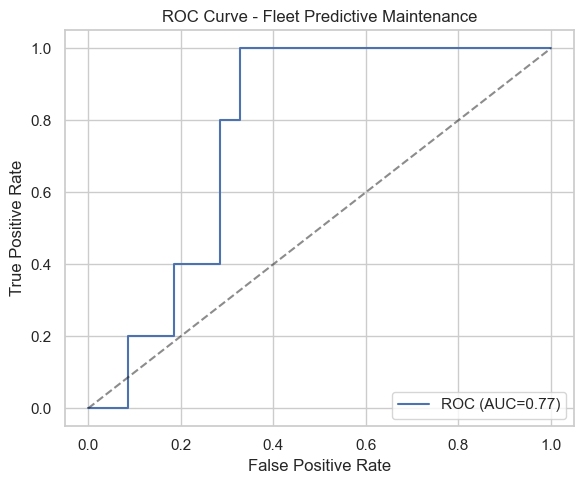

Suggested threshold (Youden J): 0.128


In [7]:
# Curva ROC y umbral sugerido
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.2f})')
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Fleet Predictive Maintenance')
plt.legend()
plt.tight_layout()
plt.savefig(data_out / 'roc_curve.png', dpi=150)
plt.show()
# Umbral con Youden J (tpr - fpr)
j_scores = tpr - fpr
idx = int(np.argmax(j_scores))
best_thresh = thresholds[idx]
print(f'Suggested threshold (Youden J): {best_thresh:.3f}')

#### 📐 ROC/AUC y umbrales
- ROC: barrido de umbrales sobre `y_proba`; AUC ∈ [0,1], mayor es mejor.
- Youden J: maximiza `tpr - fpr` y da un umbral operativo balanceado.
- Umbral económico (opcional): minimizar `E[costo] = C_FN·FN + C_FP·FP + C_MT·TP`, donde `C_FN`≈ downtime (USD) y `C_MT`≈ costo de mantenimiento preventivo.
- En LATAM, costos logísticos suelen elevar `C_FN`; preferir mayor sensibilidad (menos FN).

### 🗓️ Sugerencia de ventanas de mantenimiento
- Asignamos `risk_score = y_proba` y clasificamos por percentiles.
- Ventanas: Alta prioridad (top 20%), Media (20–50%), Baja (>50%).
- Minimiza impacto programando fuera de horas pico y en hubs con mayor capacidad.

In [8]:
# Construcción de plan de mantenimiento
test_df = df.loc[X_test.index].copy()
test_df['risk_score'] = y_proba
# Clasificación por percentiles
p = np.percentile(test_df['risk_score'], [80,50])
hi, mid = p[0], p[1]
def bucket(r):
    if r >= hi: return 'High (service soon)'
    if r >= mid: return 'Medium (plan window)'
    return 'Low (monitor)'
test_df['maint_bucket'] = test_df['risk_score'].apply(bucket)
# Ventana sugerida (semana del mes) basada en región y bucket
week_map = {'High (service soon)': 1, 'Medium (plan window)': 2, 'Low (monitor)': 4}
test_df['suggested_week'] = test_df['maint_bucket'].map(week_map)
# Exportes
df.to_parquet(data_out / 'fleet_sensor_data.parquet', index=False)
imp.to_parquet(data_out / 'feature_importance.parquet', index=False)
test_df[['unit_id','region','risk_score','maint_bucket','suggested_week','maint_cost_usd']].to_parquet(data_out / 'maintenance_plan.parquet', index=False)
print(f'✅ Exportados artefactos en: {data_out}')

✅ Exportados artefactos en: f:\GitHub\supply-chain-data-notebooks\data\processed\rt02_predictive_maintenance


#### 🗓️ Heurística de programación de mantenimiento
- Priorización por percentiles de riesgo: alta (≥p80), media (p50–p80), baja (<p50).
- Semana sugerida por bucket para repartir carga operativa; puede ajustarse por `region`/capacidad de taller.
- Extensión: Optimización entera (asignación por capacidad, ventanas y SLAs) o simulación de agenda.

### 💰 Consideraciones económicas (USD)
- `maint_cost_usd`: costo estimado de intervención por unidad.
- Sugerir ventanas que minimicen `downtime` y costo logístico (LATAM).
- Extender con costo esperado: `E[costo_falla] = p_fail * costo_downtime`.

In [9]:
# Validaciones finales
import os
expected = ['fleet_sensor_data.parquet','feature_importance.parquet','maintenance_plan.parquet','roc_curve.png']
for f in expected:
    assert (data_out / f).exists(), f'Missing: {f}'
    print(f'✅ {f} exists')
# Rango de métricas
assert 0 <= auc <= 1, 'AUC fuera de rango'
assert test_df['risk_score'].between(0,1).all(), 'riesgo fuera de [0,1]'
assert set(test_df['maint_bucket'].unique()) == {'High (service soon)','Medium (plan window)','Low (monitor)'}
print('🎉 Notebook RT-02 ejecutado y validado')

✅ fleet_sensor_data.parquet exists
✅ feature_importance.parquet exists
✅ maintenance_plan.parquet exists
✅ roc_curve.png exists
🎉 Notebook RT-02 ejecutado y validado


## 📘 Explicaciones Técnicas y Supuestos
- Datos sintéticos calibrados para reflejar operación LATAM.
- Modelo sencillo para reproducibilidad; puede sustituirse por XGBoost si está disponible.
- Umbral por Youden J; ajustar según costos y SLA.
- Ventanas por percentiles para priorizar sin saturar talleres.
- Extensiones: series temporales por unidad, drift de sensores, costos detallados, integración IoT streaming.